In [1]:
import torch
torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

Basics

In [2]:
x = torch.arange(12, dtype = torch.float32)
x.shape
X = x.reshape(3,4)
X

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

In [3]:
x = torch.tensor([1,2,3]).reshape(3,1)
y = torch.tensor([4,5,6]).reshape(1,3)

x, y


(tensor([[1],
         [2],
         [3]]),
 tensor([[4, 5, 6]]))

In [4]:
import os

os.makedirs(os.path.join('..','data'), exist_ok = True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')

with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # Column names
    f.write('NA,Pave,127500\n')  # Each row represents a data example
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

In [5]:
import pandas as pd

data = pd.read_csv(data_file)
print(data)

   NumRooms Alley   Price
0       NaN  Pave  127500
1       2.0   NaN  106000
2       4.0   NaN  178100
3       NaN   NaN  140000


In [6]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:,2]

inputs = inputs.fillna(inputs.mean())

inputs = pd.get_dummies(inputs, dummy_na = True)

print(inputs)

   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1


C:\Users\iamwl\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)

X, y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

In [8]:
X.T, y

(tensor([[3., 2., 4., 3.],
         [1., 0., 0., 0.],
         [0., 1., 1., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

In [9]:
torch.mv(X.T, y.double())

tensor([1726900.,  127500.,  424100.], dtype=torch.float64)

Autograd

In [10]:
x = torch.arange(4.0)
x.requires_grad_(True)
x, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True), None)

In [11]:
y = 2 * torch.dot(x, x)

y

tensor(28., grad_fn=<MulBackward0>)

In [12]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [13]:
x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [14]:
x.grad.zero_()
y = x*x 
u = y.detach()
z = u * x

x, y, u, z

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [15]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [16]:
a = torch.randn(size=(3,), requires_grad=True)
d = f(a)
d.sum().backward()

a, d, a.grad, d / a

(tensor([ 1.8239,  0.0050, -0.3042], requires_grad=True),
 tensor([1867.6642,    5.0746, -311.5387], grad_fn=<MulBackward0>),
 tensor([1024., 1024., 1024.]),
 tensor([1024., 1024., 1024.], grad_fn=<DivBackward0>))

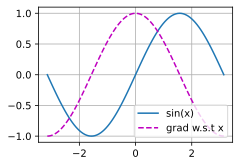

In [17]:
import numpy as np
from d2l import torch as d2l

x = np.linspace(- np.pi,np.pi,100)
x = torch.tensor(x, requires_grad=True)
y = torch.sin(x)
y.sum().backward()

d2l.plot(x.detach(),(y.detach(),x.grad),legend = (('sin(x)',"grad w.s.t x")))

Probability

In [18]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.]])

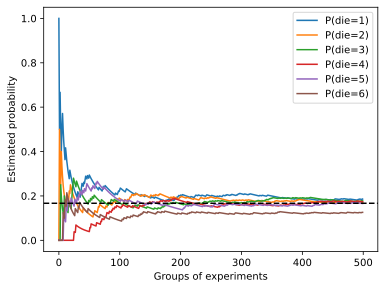

In [19]:
fair_probs = torch.ones([6]) / 6
counts = multinomial.Multinomial(1, fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend()
counts

In [20]:
help(torch.tensor)

Help on built-in function tensor:

tensor(...)
    tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor
    
    Constructs a tensor with :attr:`data`.
    
    .. warning::
    
        :func:`torch.tensor` always copies :attr:`data`. If you have a Tensor
        ``data`` and want to avoid a copy, use :func:`torch.Tensor.requires_grad_`
        or :func:`torch.Tensor.detach`.
        If you have a NumPy ``ndarray`` and want to avoid a copy, use
        :func:`torch.as_tensor`.
    
    .. warning::
    
        When data is a tensor `x`, :func:`torch.tensor` reads out 'the data' from whatever it is passed,
        and constructs a leaf variable. Therefore ``torch.tensor(x)`` is equivalent to ``x.clone().detach()``
        and ``torch.tensor(x, requires_grad=True)`` is equivalent to ``x.clone().detach().requires_grad_(True)``.
        The equivalents using ``clone()`` and ``detach()`` are recommended.
    
    Args:
        data (array_like): Initia